# Aquire & Analyze
#### Megan Albee, Craig Stahlberg, Jamie Robertson
##### Fall 2022

This notebook scrapes data from the eBird application website. App owners report sightings of specific birds, in specific locations, at specific times like other birding checklists as well as length of time looking, survey protocol, and how many birders are in their group. The data available via a free api key goes back 30 days and can be pulled for locations around the world. eBird uses citizen scientist to populate a pretty friendly and accessable database. This notebook uses an api wrapper that is freely available and it helps to extract the location information from eBird encounters.  


In [1]:
import requests
import json
import http.client
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import folium 
from folium.plugins import HeatMap 
%matplotlib inline
sns.set()

import sys
import glob
import wikipedia
import time
from progress.bar import Bar

from flickrapi import FlickrAPI

from IPython import display
from IPython.display import Image, display


from collections import Counter
from collections import defaultdict
from string import punctuation
from pprint import pprint
from nltk.corpus import stopwords

In [2]:
#ProjectBabbler shared an api wrapper on github that is very nice
from PIL import Image
from ebird.api import get_observations
from ebird.api import get_hotspots, get_nearby_hotspots, get_hotspot
from ebird.api import get_nearby_observations
from ebird.api import get_notable_observations, get_nearby_notable, get_species_observations, get_nearby_species
from ebird.api import get_visits, get_checklist
#api keys were easily obtained from eBird and generated automatically after filling out a form
api_key = ''

The data aquired from eBird will be analyzed using the folium package. Folium provides data visualization functions with variety of mapping features available. For this assignment, several mapping functions will be used to view and interpret the data. Before the data can be mapped, it is pulled from eBird. The last 30 days of records from the State of Montana are collected. 

In [3]:
# get records from the state of Montana
records = get_observations(api_key, 'US-MT', back=30)
len(records)

print(f'There are {len(records)} recorded observations. A number of birds are recorded in each observation')
# this doesn't work - print(f'There are {sum(records.howMany)} birds represented.')

There are 168 recorded observations. A number of birds are recorded in each observation


The records are moved into a database for further analysis. Using the Folium interactve world map and heat map overlay, the number of birds observed are illustrated in the heat map. As observations are continuously reported and the 30-day rolling window marches forward, the map will be updated with current information everytime this notebook is run. 

In [4]:
# put data into df
MT_df =pd.DataFrame.from_dict(records)
MT_df.head(15)

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId,exoticCategory
0,cangoo,Canada Goose,Branta canadensis,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,9,46.741784,-111.886121,True,False,True,S123596036,NaN
1,comgol,Common Goldeneye,Bucephala clangula,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,100,46.741784,-111.886121,True,False,True,S123596036,NaN
2,amedip,American Dipper,Cinclus mexicanus,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,1,46.741784,-111.886121,True,False,True,S123596036,NaN
3,mallar3,Mallard,Anas platyrhynchos,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,7,46.741784,-111.886121,True,False,True,S123596036,NaN
4,horlar,Horned Lark,Eremophila alpestris,L21735496,"Interstate 15, Dillon, Montana, US (45.327, -1...",2022-12-07 09:31,20,45.327207,-112.687811,True,False,True,S123595162,NaN
5,bkbmag1,Black-billed Magpie,Pica hudsonia,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,3,46.826294,-113.998449,True,False,True,S123595394,NaN
6,pilwoo,Pileated Woodpecker,Dryocopus pileatus,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,1,46.826294,-113.998449,True,False,True,S123595394,NaN
7,norfli,Northern Flicker,Colaptes auratus,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,1,46.826294,-113.998449,True,False,True,S123595394,NaN
8,comrav,Common Raven,Corvus corax,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,2,46.826294,-113.998449,True,False,True,S123595394,NaN
9,houfin,House Finch,Haemorhous mexicanus,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,21,46.826294,-113.998449,True,False,True,S123595394,NaN


In [5]:
MT_df = MT_df.drop('exoticCategory',axis=1)

In [6]:
MT_df = MT_df.dropna()
MT_df.head(15)

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,cangoo,Canada Goose,Branta canadensis,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,9,46.741784,-111.886121,True,False,True,S123596036
1,comgol,Common Goldeneye,Bucephala clangula,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,100,46.741784,-111.886121,True,False,True,S123596036
2,amedip,American Dipper,Cinclus mexicanus,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,1,46.741784,-111.886121,True,False,True,S123596036
3,mallar3,Mallard,Anas platyrhynchos,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,7,46.741784,-111.886121,True,False,True,S123596036
4,horlar,Horned Lark,Eremophila alpestris,L21735496,"Interstate 15, Dillon, Montana, US (45.327, -1...",2022-12-07 09:31,20,45.327207,-112.687811,True,False,True,S123595162
5,bkbmag1,Black-billed Magpie,Pica hudsonia,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,3,46.826294,-113.998449,True,False,True,S123595394
6,pilwoo,Pileated Woodpecker,Dryocopus pileatus,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,1,46.826294,-113.998449,True,False,True,S123595394
7,norfli,Northern Flicker,Colaptes auratus,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,1,46.826294,-113.998449,True,False,True,S123595394
8,comrav,Common Raven,Corvus corax,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,2,46.826294,-113.998449,True,False,True,S123595394
9,houfin,House Finch,Haemorhous mexicanus,L6288607,"Ben Hogan Dr open space, Missoula US-MT (46.82...",2022-12-07 08:53,21,46.826294,-113.998449,True,False,True,S123595394


In [7]:
#Okay but now we want to see where the birds are
#A heat map easily tells us the density of birds. 

birds = zip(MT_df['lat'], MT_df['lng'], MT_df['howMany'])
list_of_zip = list(birds)
list_of_zip[0:10] 

[(46.741784, -111.886121, 9),
 (46.741784, -111.886121, 100),
 (46.741784, -111.886121, 1),
 (46.741784, -111.886121, 7),
 (45.3272068, -112.687811, 20),
 (46.826294, -113.998449, 3),
 (46.826294, -113.998449, 1),
 (46.826294, -113.998449, 1),
 (46.826294, -113.998449, 2),
 (46.826294, -113.998449, 21)]

In [8]:
birds

In [9]:
#blank interactive world map
folium_map = folium.Map()
#folium_map

#we want the map to open up in Montana
helena = [46.58976, -111.0212] #lat,long
folium_map = folium.Map(location=helena, zoom_start = 6.5, titles = "OpenStreetMap")
#folium_map

In [10]:
#add location information to heatmap layer
hm_layer = HeatMap(list_of_zip,
                   radius = 8)
folium_map.add_child(hm_layer)

Now let's say that this report is run for birders who live around the University of Montana in Missoula. It is assumed that this community is interested in birding hotspots with 80 miles of the University. The following map provides a parachute marker on the Univeristy and circular marker to distinguish bird sightings within the acceptable range. 

In [11]:
# Circular marker 
folium.CircleMarker(location = [46.86003, -113.98378], radius = 80, popup = 'My Location').add_to(folium_map)

# Parachute markers and add a line between two locations
folium.Marker([46.86003, -113.98378], popup = 'University of Montana').add_to(folium_map)
#folium.Marker([24.7077, 66.0501], popup = 'Location 2').add_to(folium_map)
#folium.PolyLine(locations = [(24.860966, 66.990501), (24.7077, 66.0501)], line_opacity = 0.5).add_to(folium_map)
folium_map

What if we were concerned more about the types of birds, rather than the location? Folium visualizations also include bar graphs. The bar graph below shows the 10 most highly reported bird species in Montana based on the eBird data. 

In [12]:
MT_df.query("comName=='Canada Goose'")

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,cangoo,Canada Goose,Branta canadensis,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,9,46.741784,-111.886121,True,False,True,S123596036


In [13]:
## Group by common name and sum the number observed
bird_groups = MT_df.groupby('comName').howMany.sum().reset_index()


bird_tops = bird_groups.nlargest(10, 'howMany')
bird_tops

,comName,howMany
124,Redhead,600
33,Canvasback,240
0,American Coot,200
42,Common Goldeneye,100
69,Greater Scaup,80
135,Sandhill Crane,75
13,Barrow's Goldeneye,52
123,Red-winged Blackbird,46
126,Ring-necked Duck,46
24,Brewer's Blackbird,45


In [14]:
MT_tops = MT_df.nlargest(10, 'howMany')
MT_tops

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
47,redhea,Redhead,Aythya americana,L1297661,Flathead Lake--Somers Bay,2022-12-06 15:42,600,48.074409,-114.235496,True,False,False,S123575089
43,canvas,Canvasback,Aythya valisineria,L1297661,Flathead Lake--Somers Bay,2022-12-06 15:42,240,48.074409,-114.235496,True,False,False,S123575089
46,y00475,American Coot,Fulica americana,L1297661,Flathead Lake--Somers Bay,2022-12-06 15:42,200,48.074409,-114.235496,True,False,False,S123575089
1,comgol,Common Goldeneye,Bucephala clangula,L21277738,"6563 Hauser Dam Rd, Helena US-MT 46.74178, -11...",2022-12-07 09:36,100,46.741784,-111.886121,True,False,True,S123596036
41,gresca,Greater Scaup,Aythya marila,L1297661,Flathead Lake--Somers Bay,2022-12-06 15:42,80,48.074409,-114.235496,True,False,False,S123575089
129,sancra,Sandhill Crane,Antigone canadensis,L2226858,778 10 Mile Rd,2022-11-29 10:00,75,47.325007,-111.476641,True,True,True,S123215204
87,bargol,Barrow's Goldeneye,Bucephala islandica,L1791250,West Bank Park,2022-12-05 13:12,52,47.514121,-111.312089,True,False,False,S123531589
59,rinduc,Ring-necked Duck,Aythya collaris,L247305,Central Park Pond,2022-12-06 12:36,46,45.828482,-111.284133,True,False,False,S123572976
93,rewbla,Red-winged Blackbird,Agelaius phoeniceus,L1772244,Flathead House,2022-12-05 08:35,46,48.176871,-114.137772,True,False,True,S123507533
11,houspa,House Sparrow,Passer domesticus,L9390840,"4678 Rolling Road, Ronan, Montana, US (47.559,...",2022-12-07 08:37,45,47.558655,-114.213227,True,False,True,S123592875


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Redhead'),
  Text(1, 0, 'Canvasback'),
  Text(2, 0, 'American Coot'),
  Text(3, 0, 'Common Goldeneye'),
  Text(4, 0, 'Greater Scaup'),
  Text(5, 0, 'Sandhill Crane'),
  Text(6, 0, "Barrow's Goldeneye"),
  Text(7, 0, 'Red-winged Blackbird'),
  Text(8, 0, 'Ring-necked Duck'),
  Text(9, 0, "Brewer's Blackbird")])

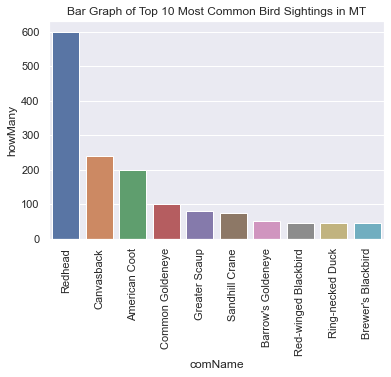

In [15]:
sns.barplot(x = 'comName', y = 'howMany', data = bird_tops)
plt.title("Bar Graph of Top 10 Most Common Bird Sightings in MT")
plt.xticks(rotation=90)

## Bird Photos and Descriptions

In [16]:
sci_name = MT_tops['sciName']

In [17]:
com_bird_names = MT_tops['comName']

In [18]:
bird_query = []

for name in com_bird_names :
    if name == "Redhead" :
        print(f'{name} is not a good bird name to search')
    else: 
        bird_query.append(name)

Redhead is not a good bird name to search


In [19]:
bird_query

['Canvasback',
 'American Coot',
 'Common Goldeneye',
 'Greater Scaup',
 'Sandhill Crane',
 "Barrow's Goldeneye",
 'Ring-necked Duck',
 'Red-winged Blackbird',
 'House Sparrow']

## Get Bird Images via Flickr

In [20]:
 def create_folder(path):
    if not os.path.isdir(path):
        os.makedirs(path)

In [21]:
def download_images(urls, path):
    create_folder(path)  # makes sure path exists

    for url in urls:
        image_name = url.split("/")[-1]
        image_path = os.path.join(path, image_name)

        if not os.path.isfile(image_path):  # ignore if already downloaded
            response=requests.get(url,stream=True)

            with open(image_path,'wb') as outfile:
                outfile.write(response.content)

In [22]:


KEY = ''
SECRET = ''

# List of sizes:
# url_o: Original (4520 × 3229)
# url_k: Large 2048 (2048 × 1463)
# url_h: Large 1600 (1600 × 1143)
# url_l=: Large 1024 (1024 × 732)
# url_c: Medium 800 (800 × 572)
# url_z: Medium 640 (640 × 457)
# url_m: Medium 500 (500 × 357)
# url_n: Small 320 (320 × 229)
# url_s: Small 240 (240 × 171)
# url_t: Thumbnail (100 × 71)
# url_q: Square 150 (150 × 150)
# url_sq: Square 75 (75 × 75)

SIZES = ["url_m"]  # order of preference

def get_photos(image_tag):
    extras = ','.join(SIZES)
    flickr = FlickrAPI(KEY, SECRET)
    photos = flickr.walk(text=image_tag,
                            extras=extras,  # get the url for the original size image
                            privacy_filter=1,  # search only for public photos
                            per_page=50,
                            sort='relevance')
    return photos

def get_url(photo):
    for i in range(len(SIZES)):
        url = photo.get(SIZES[i])
        if url:  # if url is None try with the next size
            return url

def get_urls(image_tag, max):
    photos = get_photos(image_tag)
    counter=0
    urls=[]

    for photo in photos:
        if counter < max:
            url = get_url(photo)  # get preffered size url
            if url:
                urls.append(url)
                counter += 1
            # if no url for the desired sizes then try with the next photo
        else:
            break

    return urls


In [23]:
all_species = bird_query
images_per_species = 1

def download():
    for species in all_species:

        print('Getting urls for', species)
        urls = get_urls(species, images_per_species)
        
        print('Downloading images for', species)
        path = os.path.join('data', species)

        download_images(urls, path)

if __name__=='__main__':

    start_time = time.time()

    download()

    print('Took', round(time.time() - start_time, 2), 'seconds')

Getting urls for Canvasback
Getting urls for American Coot
Getting urls for Common Goldeneye
Getting urls for Greater Scaup
Getting urls for Sandhill Crane
Getting urls for Barrow's Goldeneye
Getting urls for Ring-necked Duck
Getting urls for Red-winged Blackbird
Getting urls for House Sparrow
Took 3.72 seconds


In [24]:
bird_list_img = []
for name in com_bird_names :
    for file in glob.glob(f'/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/{name}/*.jpg'): 
        bird_list_img.append(file)

### Printing out Birds based on the top ten most common birds

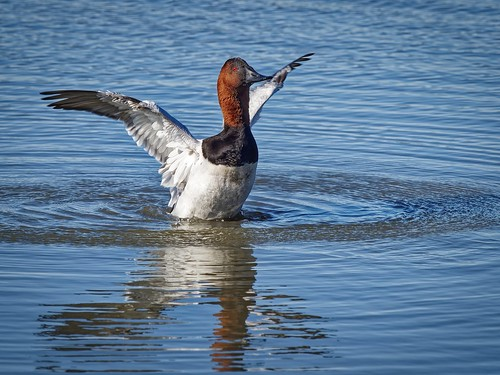

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Canvasback/51829798305_2706e74c2c.jpg


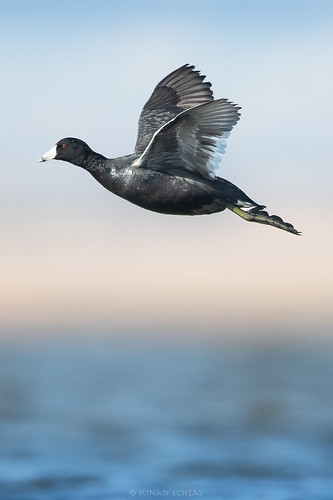

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/American Coot/51201844130_caf1568aa4.jpg


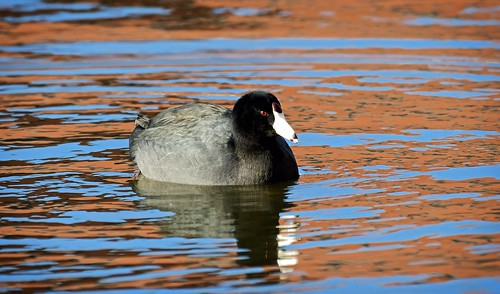

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/American Coot/49422541712_22b35e881b.jpg


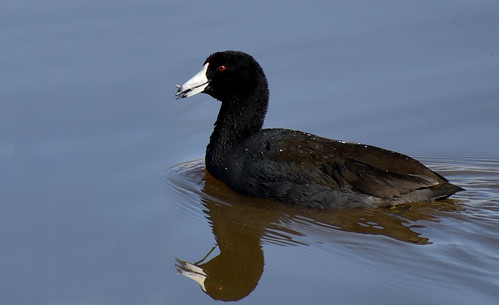

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/American Coot/40160823261_627228710e.jpg


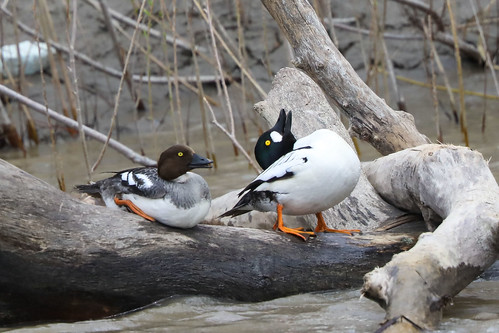

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Common Goldeneye/52185036441_f6f9b72222.jpg


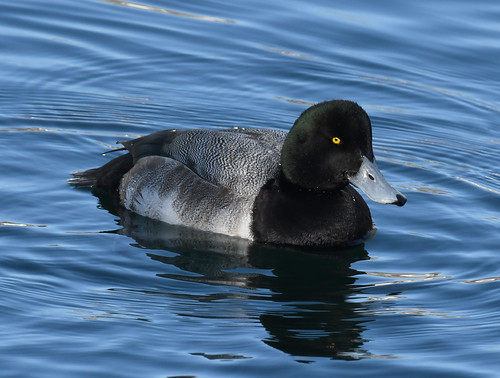

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Greater Scaup/51137567503_67e19553ec.jpg


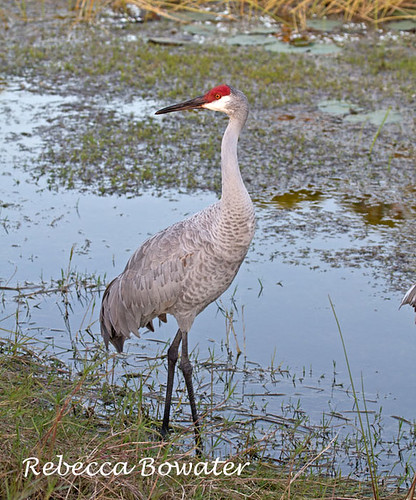

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Sandhill Crane/33408429842_e37ea22945.jpg


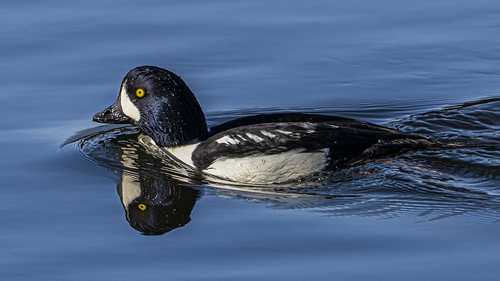

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Barrow's Goldeneye/51669104134_e203a8113f.jpg


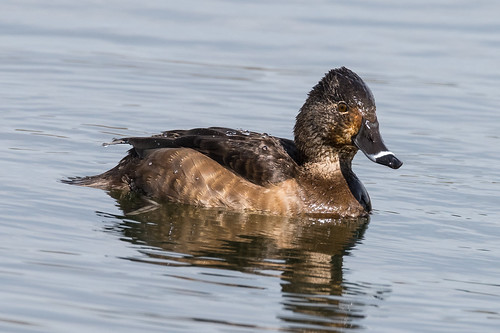

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Ring-necked Duck/40052713655_88ea2ee9dd.jpg


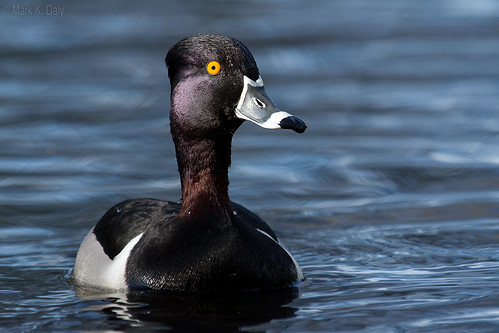

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Ring-necked Duck/25828392764_a5cc7921d9.jpg


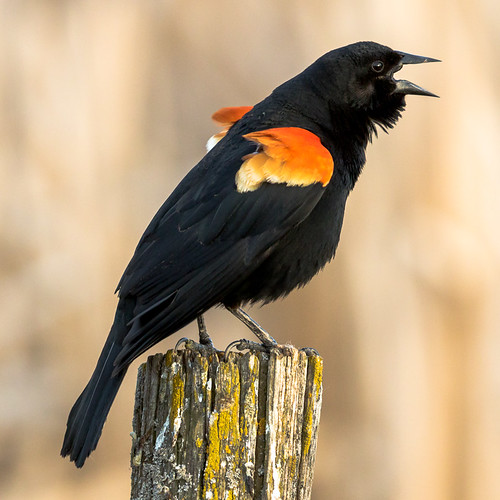

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Red-winged Blackbird/33751224374_e20ed4522b.jpg


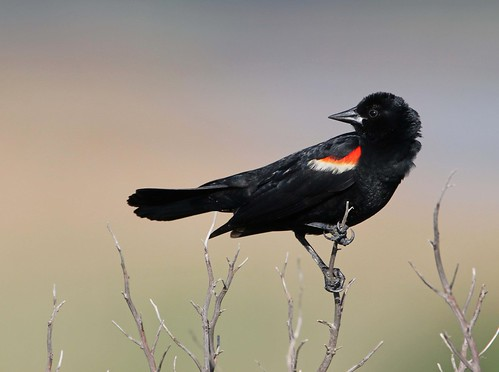

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/Red-winged Blackbird/18078765121_5d54487a01.jpg


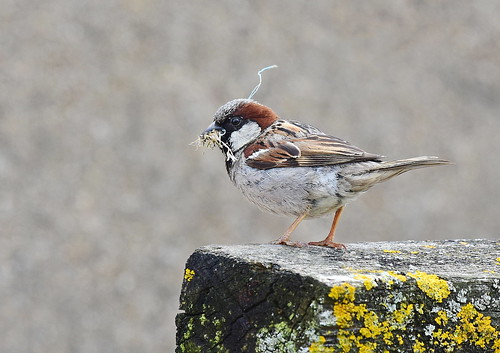

/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/House Sparrow/51231444273_7cd68036f8.jpg


In [27]:
for name in com_bird_names :
    for file in glob.glob(f'/Users/meganalbee/Desktop/Text Mining/ebird/ADA-birds/data/{name}/*.jpg'): 
        display(Image(filename=file))
        print(file)
        

# Wikipedia Bird Descriptions 

In [28]:
bird_dict = {}

for bird in sci_name : 
    bird_dict[bird] = wikipedia.summary(f"{bird}", sentences=2)

In [29]:
bird_dict

{'Aythya americana': 'The redhead (Aythya americana) is a medium-sized diving duck. The scientific name is derived from Greek aithuia, an unidentified seabird mentioned by authors including Hesychius and Aristotle, and Latin americana, of America.',
 'Aythya valisineria': 'The canvasback (Aythya valisineria) is a species of diving duck, the largest found in North America.\n\n\n== Taxonomy ==\nScottish-American naturalist Alexander Wilson described the canvasback in 1814.',
 'Fulica americana': 'The American coot (Fulica americana), also known as a mud hen or pouldeau, is a bird of the family Rallidae. Though commonly mistaken for ducks, American coots are only distantly related to ducks, belonging to a separate order.',
 'Bucephala clangula': "The common goldeneye or simply goldeneye (Bucephala clangula) is a medium-sized sea duck of the genus Bucephala, the goldeneyes. Its closest relative is the similar Barrow's goldeneye.",
 'Aythya marila': 'The greater scaup (Aythya marila), just 

### Get word Patterns for Bird Descriptions

In [30]:
sw = stopwords.words('english')

def get_patterns(text)  :
    
    
    """
        This function takes text as an input and returns a dictionary of statistics,
        after cleaning the text. 
    
    """
    
#     We'll make things a big clearer by initializing the 
#     statistics here. These are placeholder values.
    total_tokens = 0
    unique_tokens = 0 
    avg_token_len = 0.0
    lex_diversity = 0.0
    top_10 = Counter()
    
    # Do your tokenization and normalization here
    
    text = [w.lower() for w in text if w.lower() not in sw and w.isalpha()]
    
    # Calculate your statistics here
    total_tokens = len(text)
    unique_tokens = len(set(text))
    avg_token_len = sum(len(w) for w in text)/len(text)
    lex_diversity = unique_tokens/total_tokens
    text_count = Counter(text)
    top_10 = text_count.most_common(10)
    
    
    # Now we'll fill out the dictionary. 
    results = {'tokens':total_tokens,
               'unique_tokens':unique_tokens,
               'avg_token_length':avg_token_len,
               'lexical_diversity':lex_diversity,
               'top_10':top_10}

    return(results)


In [31]:
text = []

for bird in bird_dict :
    text = bird_dict[bird]
    text = text.split()
    
    print(bird, get_patterns(text))

Aythya americana {'tokens': 13, 'unique_tokens': 13, 'avg_token_length': 7.461538461538462, 'lexical_diversity': 1.0, 'top_10': [('redhead', 1), ('diving', 1), ('scientific', 1), ('name', 1), ('derived', 1), ('greek', 1), ('unidentified', 1), ('seabird', 1), ('mentioned', 1), ('authors', 1)]}
Aythya valisineria {'tokens': 12, 'unique_tokens': 11, 'avg_token_length': 7.666666666666667, 'lexical_diversity': 0.9166666666666666, 'top_10': [('canvasback', 2), ('species', 1), ('diving', 1), ('largest', 1), ('found', 1), ('north', 1), ('taxonomy', 1), ('naturalist', 1), ('alexander', 1), ('wilson', 1)]}
Fulica americana {'tokens': 17, 'unique_tokens': 16, 'avg_token_length': 6.176470588235294, 'lexical_diversity': 0.9411764705882353, 'top_10': [('american', 2), ('coot', 1), ('also', 1), ('known', 1), ('mud', 1), ('hen', 1), ('bird', 1), ('family', 1), ('though', 1), ('commonly', 1)]}
Bucephala clangula {'tokens': 10, 'unique_tokens': 9, 'avg_token_length': 6.4, 'lexical_diversity': 0.9, 'top_